In [1]:
import os
from datetime import datetime, timedelta
import urllib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import pandas as pd
from tqdm import tqdm
import re


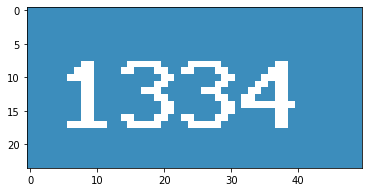

In [3]:

def date2query(date):
    return urllib.parse.quote(date.strftime('%d/%m/%Y'), safe='')

# Robust request function that automatically retries
def retry_request(url, session, total=4, status_forcelist=[429, 500, 502, 503, 504], **kwargs):
    for _ in range(total):
        try:
            response = session.get(url, **kwargs)
            if response.status_code in status_forcelist:
                continue
            return response
        except requests.exceptions.ConnectionError:
            pass
    return None

session = requests.Session()
LOGIN_URL = 'http://www.watchyourpower.org/admin/'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36'
}

page_text = retry_request(url=LOGIN_URL, session=session, headers=HEADERS)
img_url = 'http://www.watchyourpower.org/captcha.php'
img_data = retry_request(url=img_url, session=session, headers=HEADERS).content

with open('./captcha.jpg', 'wb') as fp:
    fp.write(img_data)

image = mpimg.imread("./captcha.jpg")
plt.imshow(image)
plt.show()
img_code = input('Enter captcha：')


In [4]:

USERNAME = 'junrentschler'
PASSWORD = 'jun@2018'
data = {'username': USERNAME, 'password': PASSWORD, 'code': img_code, 'login': 'Login'}

index = session.post(url=LOGIN_URL, headers=HEADERS, data=data)
print(index)

DETAIL_URL = 'http://www.watchyourpower.org/reports.php?category_id=3&location_id=119&from_date=13%2F01%2F2017&to_date=13%2F02%2F2017'
detail_text = retry_request(url=DETAIL_URL, session=session, headers=HEADERS).text


<Response [200]>


In [5]:

if detail_text.find('Welcome') == -1:
    exit()

INDIA_SCRAPE_DIR = 'india_esmi'
API_URL = 'http://www.watchyourpower.org/reports.php?'


In [8]:

res = retry_request(url=API_URL, session=session, headers=HEADERS)
if res.ok:
    text = res.text
    text_list = text.split('<option value="">-- Select  --</option>')[1].split('</select>')[0]
    text_list = re.split('<option class="" | >', text_list)
    stationIDs = [elem[6:].replace('\"', '').replace(' ', '+') for elem in text_list if elem.startswith("value=")]

    last_scraped = {}
    today_string = datetime.now().strftime('%m/%d/%Y')

    if os.path.exists(INDIA_SCRAPE_DIR):
        if os.path.exists(f'{INDIA_SCRAPE_DIR}/log.txt'):
            with open(f'{INDIA_SCRAPE_DIR}/log.txt', 'r') as f:
                print('Previous scraping log found:')
                print(f'Last read: {f.readline().split(":")[1]}')
                for line in f:
                    title, id, date = line.strip().split(',')
                    last_scraped[id] = (datetime.strptime(date, '%m/%d/%Y'), title)
    else:
        os.makedirs(INDIA_SCRAPE_DIR)

    try:
        for id in stationIDs:
            url = f'http://www.watchyourpower.org/reports.php?location_id={id}'
            res = retry_request(url=url, session=session, headers=HEADERS)

            range_start = None
            range_end = None
            title = ""

            if res:
                empty_chart_match = re.search(r'<span class="empty_chart">([\S\s]*?)<\/span>', res.text)
                if empty_chart_match:
                    empty_chart_content = empty_chart_match.group(1)
                    range_start = datetime.strptime(empty_chart_content.split('From ')[1].split(' To ')[0].strip(), '%d/%m/%Y')
                    range_end = datetime.strptime(empty_chart_content.split(' To ')[1].strip(), '%d/%m/%Y')

                    # Ensure range_start begins no earlier than January 1, 2023
                    if range_start < datetime(year=2023, month=1, day=1):
                        range_start = datetime(year=2023, month=1, day=1)
                    # Ensure range_end does not exceed December 31, 2024
                    if range_end > datetime(year=2024, month=12, day=31):
                        range_end = datetime(year=2024, month=12, day=31)

                title_match = re.search(r'<h4>[\s]*?Location - (.*?), District - (.*?), State - (.*?) \..*?<\/h4>', res.text)
                location = title_match.group(1).strip()
                district = title_match.group(2).strip()
                state = title_match.group(3).strip()
                title = re.sub(r'[\s]*-[\s]*', '-', f'{location}+{district}+{state}'.replace('/', '_')).replace(' ', '_')
                print(title)
            else:
                print(f'Failed to retrieve data for station {id}')
                continue

            # Ensure range_start and range_end are not None
            if range_start is None or range_end is None:
                print(f'No valid data range for station {id}, skipping...')
                continue

            # Query start and end dates
            query_start = range_start
            query_end = query_start + timedelta(days=31)

            dates = []
            voltages = []
            with tqdm(total=(range_end - range_start).days) as pbar:
                while query_end <= range_end and query_start < query_end:
                    url = f'http://www.watchyourpower.org/reports.php?location_id={id}&from_date={date2query(query_start)}&to_date={date2query(query_end)}'
                    res = retry_request(url=url, session=session, headers=HEADERS)

                    if res:
                        text = res.text
                        pbar.set_description(f'Scraping {query_start.strftime("%m/%d/%Y")} to {query_end.strftime("%m/%d/%Y")} for station {id}')

                        test_split = text.split('linechartData = [{')
                        if len(test_split) < 2:
                            pbar.set_description(f'No data found for station {id} between {query_start.strftime("%m/%d/%Y")} and {query_end.strftime("%m/%d/%Y")}')
                            if not re.search(r'<span class="empty_chart">([\S\s]*?)<\/span>', res.text):
                                with open(f'{INDIA_SCRAPE_DIR}/error_{id}_{query_start.strftime("%m-%d-%Y")}.html', 'w') as f:
                                    f.write(text)
                        else:
                            datapoints = test_split[1].split('];')[0].split('},{')
                            for point in datapoints:
                                date = datetime.strptime(point.split('"date":"')[1].split('","')[0], '%a %b %d %Y %H:%M:%S')
                                voltage = int(point.split('"voltage":"')[1].split('"')[0])

                                dates.append(date)
                                voltages.append(voltage)

                    pbar.update((query_end - query_start).days + 1)
                    
                    query_start = query_end + timedelta(days=1)
                    query_end = query_start + timedelta(days=31)

                    if query_end > range_end:
                        query_end = range_end

            last_scraped[id] = (range_end, title)

            print(f'Total entries: {len(dates)}')
            df = pd.DataFrame({'time': dates, 'voltage': voltages})

            # Check if the file exists before trying to read the old data
            csv_file_path = f'{INDIA_SCRAPE_DIR}/{id}+{title}.csv'
            if os.path.exists(csv_file_path):
                df_old = pd.read_csv(csv_file_path)
                df = pd.concat([df_old, df], ignore_index=True)

            # Save the dataframe to CSV
            df.to_csv(csv_file_path, index=False)

    finally:
        with open(f'{INDIA_SCRAPE_DIR}/log.txt', 'w') as f:
            f.write(f'Last Scraped:{today_string}\n')
            for id, info in last_scraped.items():
                date = info[0]
                title = info[1]
                f.write(f'{title},{id},{date.strftime("%m/%d/%Y")}\n')


Previous scraping log found:
Last read: 09/24/2024

Alipur_Cachar+Cachar+Assam
No valid data range for station 887, skipping...


  0%|          | 0/350 [00:00<?, ?it/s]

Ameerpeth-Hyderabad+Hyderabad+Andhra_Pradesh_Telangana


Scraping 11/17/2023 to 12/17/2023 for station 171: : 351it [00:35,  9.86it/s]                       


Total entries: 479760


  0%|          | 0/359 [00:00<?, ?it/s]

Amrit_Nagar_Hazaribagh+Hazaribagh+Jharkhand


Scraping 12/19/2023 to 12/26/2023 for station 905: : 360it [00:35, 10.00it/s]                       


Total entries: 517800


  0%|          | 0/359 [00:00<?, ?it/s]

Aundh-Pune+Pune+Maharashtra


Scraping 12/19/2023 to 12/26/2023 for station 130: : 360it [00:39,  9.10it/s]                       


Total entries: 517800
Banjara_hills_Hyderabad+Hyderabad+Telangana
No valid data range for station 673, skipping...


0it [00:00, ?it/s]

Besant_Nagar_Chennai+Kancheepuram+Tamil_Nadu
Total entries: 0



0it [00:00, ?it/s]
  0%|          | 0/311 [00:00<?, ?it/s]

Bhopoli-Palghar+Palghar+Maharashtra
Total entries: 0
Bhurkunda_Ramgarh+Bhurkunda+Jharkhand


Scraping 10/16/2023 to 11/08/2023 for station 890: : 312it [00:29, 10.60it/s]                       


Total entries: 428760


  0%|          | 0/50 [00:00<?, ?it/s]

Bilasipara_Dhubri+Dhubri+Assam


Scraping 02/02/2023 to 02/20/2023 for station 864: : 51it [00:05,  9.83it/s]                      


Total entries: 72960


  0%|          | 0/338 [00:00<?, ?it/s]

Borbheta_Jorhat+Jorhat+Assam


Scraping 11/17/2023 to 12/05/2023 for station 886: : 339it [00:22, 15.20it/s]                                     


Total entries: 282540


0it [00:00, ?it/s]

Capital_Electrical_Subdivision_Guwahati+Kamrup_Metro+Assam
No valid data range for station 499, skipping...
Chanho_Ranchi+Ranchi+Jharkhand
Total entries: 0



  0%|          | 0/75 [00:00<?, ?it/s]

Chouparan_Hazaribagh+Hazaribagh+Jharkhand


Scraping 03/06/2023 to 03/17/2023 for station 904: : 76it [00:07, 10.05it/s]                      


Total entries: 108600


  0%|          | 0/293 [00:00<?, ?it/s]

Devpur-Dhule+Dhule+Maharashtra


Scraping 10/16/2023 to 10/21/2023 for station 302: : 294it [00:28, 10.31it/s]                       


Total entries: 353160


  0%|          | 0/359 [00:00<?, ?it/s]

Domadih_Godda+Godda+Jharkhand


Scraping 12/19/2023 to 12/26/2023 for station 889: : 360it [00:35, 10.22it/s]                       


Total entries: 496260


  0%|          | 0/262 [00:00<?, ?it/s]

Dudhimati_Koderma+Koderma+Jharkhand


Scraping 09/14/2023 to 09/20/2023 for station 906: : 263it [00:25, 10.19it/s]                       


Total entries: 378480


  0%|          | 0/210 [00:00<?, ?it/s]

Firozpur_Suratganj+Barabanki+Uttar_Pradesh


Scraping 07/12/2023 to 07/30/2023 for station 741: : 211it [00:21, 10.02it/s]                       


Total entries: 303180


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Haider_Nagar_Palamu+Palamu+Jharkhand
Total entries: 0
Kairo_Loardaga+Loardaga+Jharkhand
Total entries: 0



  0%|          | 0/359 [00:00<?, ?it/s]

Kapoorthala-Lucknow+Lucknow+Uttar_Pradesh
No valid data range for station 704, skipping...
Kardaitola_Nalbari+Nalbari+Assam


Scraping 12/19/2023 to 12/26/2023 for station 888: : 360it [00:36,  9.79it/s]                       


Total entries: 517800


  0%|          | 0/103 [00:00<?, ?it/s]

Khatarbari_Baksa+Baksa+Assam


Scraping 04/07/2023 to 04/14/2023 for station 910: : 104it [00:10, 10.02it/s]                      


Total entries: 146340


  0%|          | 0/359 [00:00<?, ?it/s]

Kolebira_Simdega+Simdega+Jharkhand


Scraping 12/19/2023 to 12/26/2023 for station 873: : 360it [00:27, 13.07it/s]                       


Total entries: 369480


  0%|          | 0/359 [00:00<?, ?it/s]

Kothrud_Pune+Pune+Maharashtra
No valid data range for station 875, skipping...
Lalmatia_Godda+Godda+Jharkhand


Scraping 12/19/2023 to 12/26/2023 for station 902: : 360it [00:30, 11.83it/s]                                     


Total entries: 429780


0it [00:00, ?it/s]

Mahuadanr_Latehar+Latehar+Jharkhand
Total entries: 0



0it [00:00, ?it/s]
  0%|          | 0/162 [00:00<?, ?it/s]

Malwada-Palghar+Palghar+Maharashtra
Total entries: 0
Mihijim_Jamatara+Jamatara+Jharkhand


Scraping 06/10/2023 to 06/12/2023 for station 899: : 163it [00:08, 18.58it/s]                                     


Total entries: 96120


0it [00:00, ?it/s]

Nagaon+Nagaon+Assam
Total entries: 0



0it [00:00, ?it/s]
  0%|          | 0/180 [00:00<?, ?it/s]

Netarhat_Latehar+Latehar+Jharkhand
Total entries: 0
Nichinta_Goalpara+Goalpara+Assam


Scraping 06/10/2023 to 06/30/2023 for station 909: : 181it [00:21,  8.60it/s]                       


Total entries: 259860


  0%|          | 0/55 [00:00<?, ?it/s]

Paigwa-Barabanki+Barabanki+Uttar_Pradesh


Scraping 02/02/2023 to 02/25/2023 for station 764: : 56it [00:03, 18.08it/s]                      


Total entries: 24360
